# Preprocessing mouse brains!

Here we preprocess data from Michael Ratz, Leonie von Berlin, and others (?), relating to gene expression in mouse brain cells. Cells were barcoded and then developed into various kinds of brain cells. Later, the clones were identified by barcode, and we will examine the gene expression profile of various clones and cell types.

We begin by loading packages we'll need.

# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_prefix = 'Processed/'
file_suffix = '.loom'  

In [3]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

## Loading single-cell metadata

In [4]:
directory = 'Raw/MR_umi_counts_exon_intron/'

meta_df = pd.read_csv(directory+'meta_clones.txt', sep=';')
meta_df.cloneID = meta_df.cloneID.astype(str)
meta_df.rename(columns={'CellTypes_Level4_zeisel_refined':'cell_type'}, inplace=True)
meta_df.head()


,orig.ident,nCount_RNA,nFeature_RNA,BC,Sample_ID,Sample_Plate,Sample_Well,Sample_Plate_BCSet,Ambiguity,Exon,...,description,layer,RNA_snn_res.2,RNA_snn_res.1,RNA_snn_res.0.1,condition,sex,CellTypes_Level4_zeisel_final,CellTypes_Level2,cell_type
AACCATCGGCCGAGTCCGTT,UMI_count_inex,23056,5071,AACCATCGGCCGAGTCCGTT,cell_387,201006_Plate2,6C,A3,11118,539178,...,"Telencephalon astrocytes, protoplasmic",UL,NaN,NaN,NaN,lenti,F,ACTE2,Astroependymal cells,ACTE2_DL
AACCATCGGCCTCATATCGA,UMI_count_inex,42910,7365,AACCATCGGCCTCATATCGA,cell_699,201006_Plate2,6C,N3,6803,287567,...,"Telencephalon astrocytes, protoplasmic",UL,NaN,NaN,NaN,lenti,F,ACTE2,Astroependymal cells,ACTE2_UL
AACCATCGGCGATACGCACC,UMI_count_inex,18512,4940,AACCATCGGCGATACGCACC,cell_459,201006_Plate2,6C,D3,6881,212440,...,"Telencephalon astrocytes, protoplasmic",NaN,NaN,NaN,NaN,lenti,F,ACTE2,Astroependymal cells,ACTE2_DL
AACCATCGGCTGACACCTTA,UMI_count_inex,36930,6923,AACCATCGGCTGACACCTTA,cell_651,201006_Plate2,6C,L3,11679,501663,...,"Telencephalon astrocytes, protoplasmic",UL,NaN,NaN,NaN,lenti,F,ACTE2,Astroependymal cells,ACTE2_UL
AACGTACCGTACTCGCTTGA,UMI_count_inex,23438,5650,AACGTACCGTACTCGCTTGA,cell_4766,201006_Plate13,10J,G14,3998,169916,...,"Telencephalon astrocytes, protoplasmic",UL,NaN,NaN,NaN,lenti,M,ACTE2,Astroependymal cells,ACTE2_UL


In [5]:
cells = list(meta_df.index)
meta_df['cell_type'] = meta_df['cell_type'].str.replace('_','')
cell_types = meta_df.cell_type.unique()
print('The metadata contains {} cells.'.format(len(cells)))
print('These belong to {} types: {}.'.format(len(cell_types), ', '.join(cell_types)))

The metadata contains 2210 cells.
These belong to 18 types: ACTE2DL, ACTE2UL, ACTE1, PVM1, MGL1, TEGLU7, TEGLU3, TEGLU8, TEGLU12, TEGLU10, CR, TEINH4, MOL1, MFOL1, OPC, COP1, OPCprol, NFOL1.


In [6]:
meta_df.brain = 'brain'+meta_df.brain.astype(str)
meta_df.brain

AACCATCGGCCGAGTCCGTT    brain1
AACCATCGGCCTCATATCGA    brain1
AACCATCGGCGATACGCACC    brain1
AACCATCGGCTGACACCTTA    brain1
AACGTACCGTACTCGCTTGA    brain2
                         ...  
TTGTTACTCCCTCACCGTCA    brain1
TTGTTACTCCGTAGGTACAA    brain1
TTGTTACTCCTATTCGTTGG    brain1
TTGTTACTCCTTGGAACCAA    brain1
TTGTTCGGATACTCGACCGA    brain1
Name: brain, Length: 2210, dtype: object

In [7]:
brains = meta_df.brain.unique()
print('The cells belong to {} brains: {}.'.format(len(brains), ', '.join(brains)))

The cells belong to 2 brains: brain1, brain2.


In [8]:
regions = meta_df.region.unique()
print('The cells belong to {} regions: {}.'.format(len(regions), ', '.join(regions)))

The cells belong to 1 regions: somatosensory_cortex.


In [9]:
clones = meta_df.cloneID.unique()
clone_pops = meta_df.cloneID.value_counts()
big_clones = list(clone_pops[clone_pops >= 12].index)
print('The cells belong to {} clones. \n'
      'The {} clones with at least 12 cells are:  {}.'.format(len(clones), len(big_clones), ', '.join(big_clones)))

The cells belong to 318 clones. 
The 48 clones with at least 12 cells are:  250, 259, 27, 247, 252, 255, 22, 261, 38, 257, 20, 256, 272, 113, 44, 271, 56, 30, 59, 260, 78, 71, 11, 253, 251, 19, 7, 243, 51, 13, 52, 278, 62, 1, 277, 254, 274, 9, 50, 279, 48, 133, 280, 37, 249, 12, 81, 248.


Clonal information is earlier in development -- a single clone may develop into various cell types.  To see the possibilities, we map out the populations within each clone/celltype with some clustering.  We focus on the clones with at least 12 cells for simplicity.

In [10]:
clones_1 = meta_df[meta_df['brain']=='brain1'].cloneID.unique()
clones_2 = meta_df[meta_df['brain']=='brain2'].cloneID.unique()

In [11]:
print('There are {} cloneIDs overlapping.'.format(len(set(clones_1) & set(clones_2))))

There are 0 cloneIDs overlapping.


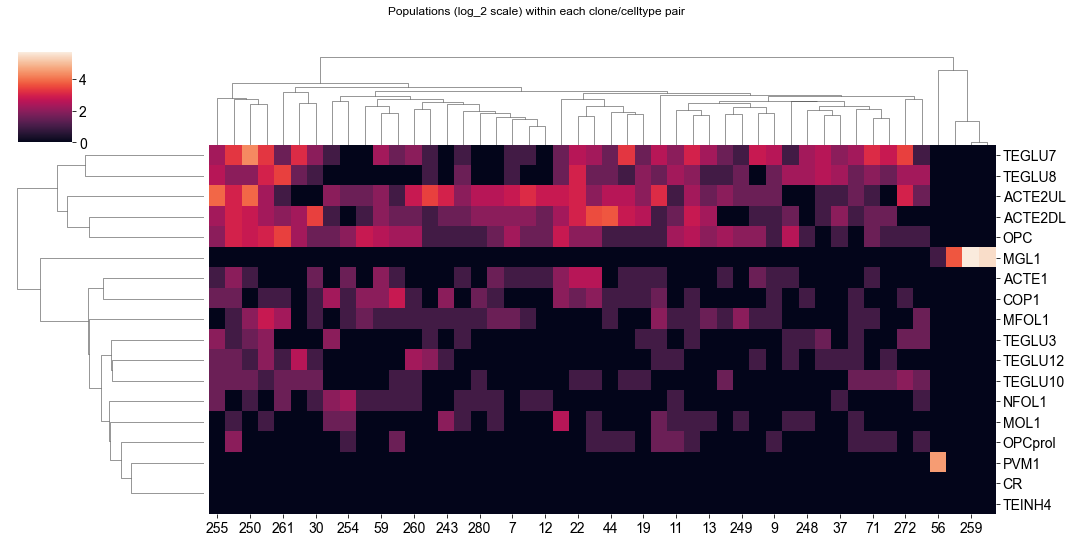

In [12]:
pop_df = pd.DataFrame(0, index = big_clones, columns = cell_types)
for cl in big_clones:
    for ct in cell_types:
        pop_df.loc[cl,ct] = len(meta_df[ (meta_df.cloneID == cl) & (meta_df.cell_type == ct)])
sns.clustermap(np.log(pop_df+1).T / np.log(2), figsize=(15,7))
plt.suptitle('Populations (log_2 scale) within each clone/celltype pair', y=1.07)
plt.show()

Above we see that clones that end up as Microglia (MG) do not also contain other cell types (except PVM1 perhaps).  But clones often end up in the TEGLU categories interchangeably, and MFOL/NFOL/MOL, and others. 

## Loading the expression matrix

Now we load the gene expression matrix.  There are two such matrices -- one with raw counts, and one more processed version.

In [13]:
data_df = pd.read_csv(directory+'data_clones.txt', sep=';')
data_df.head()

,AACCATCGGCCGAGTCCGTT,AACCATCGGCCTCATATCGA,AACCATCGGCGATACGCACC,AACCATCGGCTGACACCTTA,AACGTACCGTACTCGCTTGA,AACGTGACAAAGTCTAGAGA,AACGTGACAAATCGACGCCA,AACGTGACAACCTCCTAGGT,AACGTGACAACGATTACGTA,AACGTGACAACGGAGTGTGT,...,TTGTACCAGAGAAGACACAA,TTGTGGTTCGATACCAACCA,TTGTGGTTCGTCTCGTACTT,TTGTTACTCCAACCATCGAA,TTGTTACTCCCCTACCTGAA,TTGTTACTCCCTCACCGTCA,TTGTTACTCCGTAGGTACAA,TTGTTACTCCTATTCGTTGG,TTGTTACTCCTTGGAACCAA,TTGTTCGGATACTCGACCGA
EGFP,0.360277,1.270745,0.431906,1.77055,1.269745,0.333247,1.315171,1.912748,0.592953,0.891373,...,0.530178,0.487681,0.580763,0.877565,1.651702,0.656633,0.449716,0.282889,1.660809,0.372969
Gnai3,0.360277,0.874750,0.000000,0.00000,0.616976,0.582765,0.737239,0.570729,0.238839,0.252854,...,0.772602,0.487681,0.580763,0.423232,0.000000,0.872311,0.823167,1.285275,1.201645,0.000000
Pbsn,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cdc45,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.814068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H19,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
print('Expression matrix loaded for {} cells and {} genes.'.format(data_df.shape[1], data_df.shape[0]))

Expression matrix loaded for 2210 cells and 42614 genes.


In [15]:
data_df = data_df.T # I prefer the columns to be genes.
data_df.head()

,EGFP,Gnai3,Pbsn,Cdc45,H19,Scml2,Apoh,Narf,Cav2,Klf6,...,AC165437.1,AC131997.2,AC164883.9,AC154766.1,AC137902.2,AC154323.3,AC107711.6,AC109172.2,AC114008.2,AC118639.2
AACCATCGGCCGAGTCCGTT,0.360277,0.360277,0.0,0.0,0.0,0.0,0.000000,0.000000,0.360277,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCCTCATATCGA,1.270745,0.874750,0.0,0.0,0.0,0.0,0.000000,0.530121,0.382600,0.209487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCGATACGCACC,0.431906,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.963392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCTGACACCTTA,1.770550,0.000000,0.0,0.0,0.0,0.0,0.000000,0.432798,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACGTACCGTACTCGCTTGA,1.269745,0.616976,0.0,0.0,0.0,0.0,0.355334,0.000000,0.824163,0.616976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We look at the number of genes expressed, and the average nonzero expression, by cell type.  This is a step for quality control, and just to look for general differences between cell types.  We divide things by replicate too, as a second quality check.

In [16]:
no_genes = (data_df > 0.1).sum(axis=1)

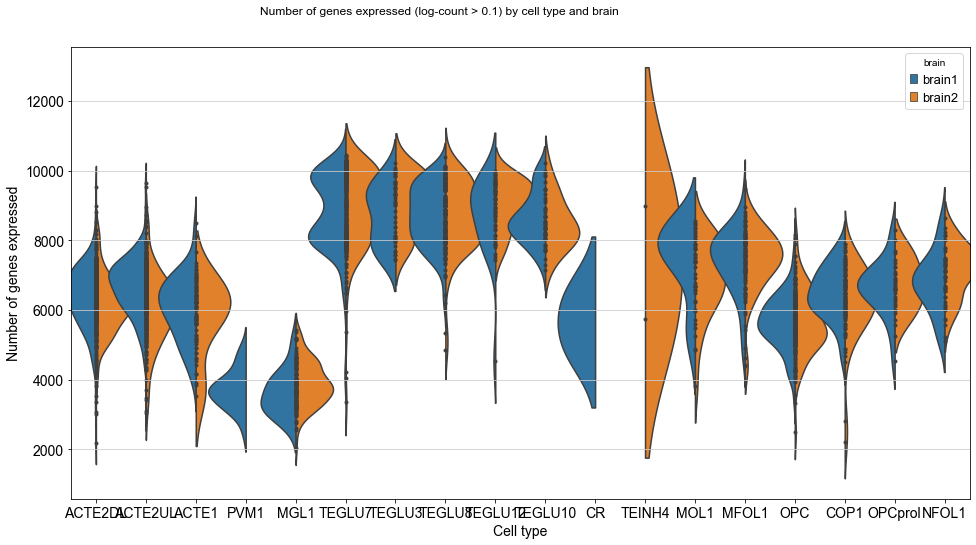

In [17]:
fig,ax = plt.subplots(figsize = (16,8))
sns.violinplot(x = meta_df.cell_type, y = no_genes, hue=meta_df.brain, ax=ax, width=1.5, inner='point', split=True)
plt.suptitle('Number of genes expressed (log-count > 0.1) by cell type and brain')
ax.set_ylabel('Number of genes expressed')
ax.set_xlabel('Cell type')
plt.show()

In [18]:
ave_nz_genes = data_df[data_df > 0.1].mean(axis=1)

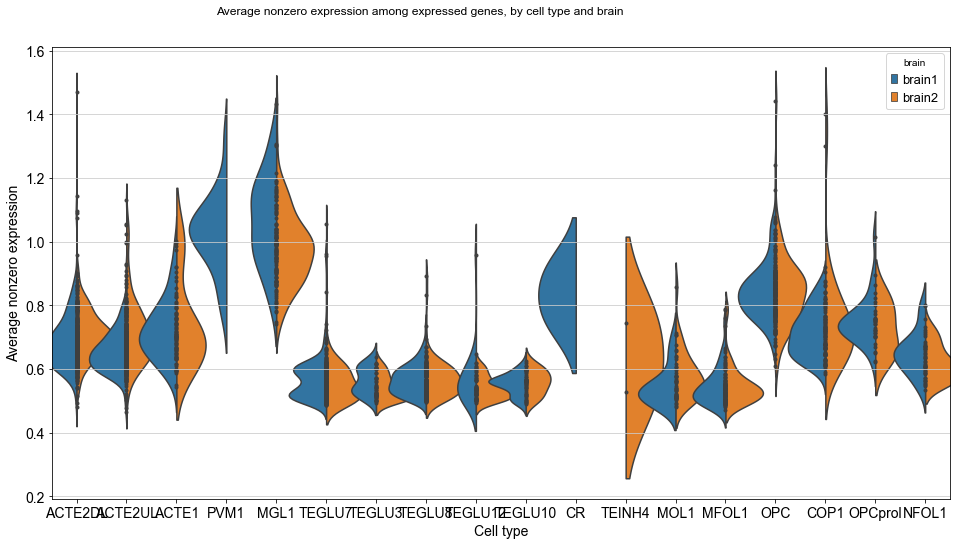

In [19]:
fig,ax = plt.subplots(figsize = (16,8))
sns.violinplot(x = meta_df.cell_type, y = ave_nz_genes, inner='point', hue=meta_df.brain, 
               width=1.5, split=True, ax=ax)
plt.suptitle('Average nonzero expression among expressed genes, by cell type and brain')
ax.set_ylabel('Average nonzero expression')
ax.set_xlabel('Cell type')
plt.show()

In [20]:
data_df

,EGFP,Gnai3,Pbsn,Cdc45,H19,Scml2,Apoh,Narf,Cav2,Klf6,...,AC165437.1,AC131997.2,AC164883.9,AC154766.1,AC137902.2,AC154323.3,AC107711.6,AC109172.2,AC114008.2,AC118639.2
AACCATCGGCCGAGTCCGTT,0.360277,0.360277,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.360277,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCCTCATATCGA,1.270745,0.874750,0.0,0.0,0.0,0.000000,0.000000,0.530121,0.382600,0.209487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCGATACGCACC,0.431906,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.963392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCTGACACCTTA,1.770550,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.432798,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACGTACCGTACTCGCTTGA,1.269745,0.616976,0.0,0.0,0.0,0.000000,0.355334,0.000000,0.824163,0.616976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTACTCCCTCACCGTCA,0.656633,0.872311,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.381271,0.381271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTACTCCGTAGGTACAA,0.449716,0.823167,0.0,0.0,0.0,0.000000,0.000000,0.249929,0.000000,0.354803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTACTCCTATTCGTTGG,0.282889,1.285275,0.0,0.0,0.0,0.000000,0.000000,0.968803,0.000000,0.503145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTACTCCTTGGAACCAA,1.660809,1.201645,0.0,0.0,0.0,0.327573,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Moving into Scanpy

We move the expression matrices, with information about genes and cells, into Scanpy's AnnData objects.

In [21]:
adata = sc.AnnData(data_df)
for cell_property in meta_df.columns:
    adata.obs[cell_property] = meta_df[cell_property]
adata.var_names_make_unique()

In [22]:
adata.to_df()

,EGFP,Gnai3,Pbsn,Cdc45,H19,Scml2,Apoh,Narf,Cav2,Klf6,...,AC165437.1,AC131997.2,AC164883.9,AC154766.1,AC137902.2,AC154323.3,AC107711.6,AC109172.2,AC114008.2,AC118639.2
AACCATCGGCCGAGTCCGTT,0.360277,0.360277,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.360277,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCCTCATATCGA,1.270745,0.874750,0.0,0.0,0.0,0.000000,0.000000,0.530121,0.382600,0.209487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCGATACGCACC,0.431906,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.963392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCATCGGCTGACACCTTA,1.770550,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.432798,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACGTACCGTACTCGCTTGA,1.269745,0.616976,0.0,0.0,0.0,0.000000,0.355334,0.000000,0.824163,0.616976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTACTCCCTCACCGTCA,0.656633,0.872311,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.381271,0.381271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTACTCCGTAGGTACAA,0.449716,0.823167,0.0,0.0,0.0,0.000000,0.000000,0.249929,0.000000,0.354804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTACTCCTATTCGTTGG,0.282889,1.285275,0.0,0.0,0.0,0.000000,0.000000,0.968803,0.000000,0.503145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTACTCCTTGGAACCAA,1.660809,1.201645,0.0,0.0,0.0,0.327573,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
adata.obs.cloneID

AACCATCGGCCGAGTCCGTT      3
AACCATCGGCCTCATATCGA      4
AACCATCGGCGATACGCACC      5
AACCATCGGCTGACACCTTA      6
AACGTACCGTACTCGCTTGA    243
                       ... 
TTGTTACTCCCTCACCGTCA     62
TTGTTACTCCGTAGGTACAA     13
TTGTTACTCCTATTCGTTGG     88
TTGTTACTCCTTGGAACCAA     71
TTGTTCGGATACTCGACCGA     24
Name: cloneID, Length: 2210, dtype: object

# Normalization and filtering

We first filter out genes which are never expressed above a count of 1, and those which are expressed in less than 5% of cells.

In [24]:
genes_before = adata.n_vars
sc.pp.filter_genes(adata, min_counts=0.01) # At least 1 count.
genes_after = adata.n_vars
print('Dataset has {} genes before and {} after filtering never-expressed.'.format(genes_before,genes_after))
sc.pp.filter_genes(adata, min_cells=0.05*adata.n_obs) # At least 5% of cells.
genes_after = adata.n_vars
print('Dataset has {} genes before and {} after filtering based on 5% of cell cutoff.'.format(genes_before,genes_after))

Dataset has 42614 genes before and 36260 after filtering never-expressed.
Dataset has 42614 genes before and 16039 after filtering based on 5% of cell cutoff.


Now we add annotations for highly variable genes.

In [25]:
print('Identifying highly variable genes.')
sc.pp.highly_variable_genes(adata, n_top_genes=7500, flavor='seurat')

Identifying highly variable genes.


In [26]:
print('Summary of AnnData object  (shape = #samples x #genes)')
print(adata)

Summary of AnnData object  (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 2210 × 16039
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'BC', 'Sample_ID', 'Sample_Plate', 'Sample_Well', 'Sample_Plate_BCSet', 'Ambiguity', 'Exon', 'Intergenic', 'Intron', 'Unmapped', 'User', 'nreadpairs', 'nNontagged', 'nUMItag', 'UMIfrac', 'nGenes', 'nGenesUMIs', 'nUMIs', 'QC', 'cellid', 'brain', 'age', 'technology', 'region', 'cloneID', 'percent.mito', 'RNA_snn_res.0.2', 'seurat_clusters', 'CellTypes_Level1', 'RNA_snn_res.0.3', 'CellTypes_Level3', 'CellTypes_Level4_zeisel', 'location', 'description', 'layer', 'RNA_snn_res.2', 'RNA_snn_res.1', 'RNA_snn_res.0.1', 'condition', 'sex', 'CellTypes_Level4_zeisel_final', 'CellTypes_Level2', 'cell_type'
    var: 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'


# Quality control

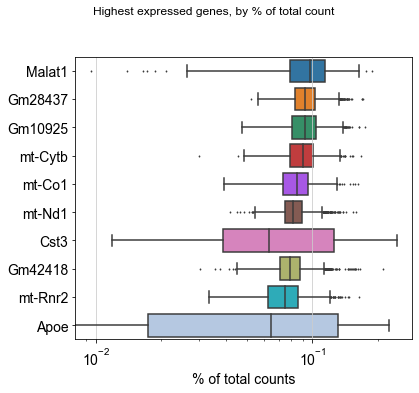

In [27]:
fig,ax = plt.subplots(1,1, figsize=(6,5))
sc.pl.highest_expr_genes(adata, n_top=10, ax=ax, log=True, show=False)
plt.suptitle('Highest expressed genes, by % of total count', y=1.05)
plt.show()

In [28]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

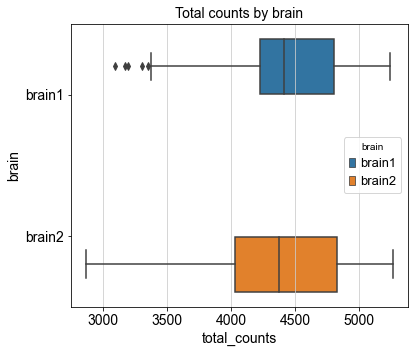

In [29]:
fig,ax = plt.subplots(1,1, figsize=(6, 5))
sns.boxplot(x='total_counts', y='brain', hue='brain', data=adata.obs,  ax=ax)
ax.set_title('Total counts by brain')
plt.show()

# Saving data

In [30]:
file_prefix

'Processed/'

In [31]:
filename = file_prefix+'Mousebrains'+file_suffix
adata.write_loom(filename)
print('Data written to {}'.format(filename))

Data written to Processed/Mousebrains.loom
